# Intro

This notebook is used to do in-depth tests and exploration of trained models. It supports one of each type of model at a time: memory (classification), time (classification), and time (regression). 

# Notebook options

There are 3 options for each model:

1. 'explore_model': Whether the notebook will explore this model at all. If False, all other options can be ignored.

2. 'path': Either 'auto', or a path to the folder creating the model's data (as saved by the model_saver object from persistence.py). If set to 'auto', the notebook will load the path from model_config.json (the same path used for apply_model.py).

3. 'training_mode': Either 'normal', 'test', or 'final'. Whether the model was trained on training data only ('normal'), training data and validation data ('test'), or training validation and testing data ('final'). This changes what data the evaluation reports and graphs are based on. In normal mode, the model will be evaluated using validation data; in test mode, the model will be evaluated using testing data; in final mode, we still use testing data, but these evaluations are practically meaningless since the model has trained on that data!

In [1]:
options = {'mem':       {'explore_model': True,
                         'path': '/glade/work/jdubeau/model-saves/mem_class_tree_test2021-07-21-17:09/',
                         'training_mode': 'test'},
           'time':      {'explore_model': False,
                         'path': 'auto',
                         'training_mode': 'final'},
           'time_regr': {'explore_model': True,
                         'path': 'auto',
                         'training_mode': 'final'}
          }

model_types = ['mem', 'time', 'time_regr']
mem_options = options['mem']
time_options = options['time']
time_regr_options = options['time_regr']

# Imports and display options

In [2]:
from math import exp
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from preprocessing import scale
from preprocessing import scale_other
from persistence import model_saver
from evaluation import print_feature_importances, \
                       plot_cm, print_cr, auc, \
                       plot_regr_performance, \
                       score_regressor
from apply_model import get_settings, predict_for_testing, \
                        custom_predict, predict_regr, \
                        translate_predictions, \
                        scale_predictions

In [3]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Loading models and associated data

First we load the settings used in apply_model.py. We primarily need the paths to each model and the scaling options.

In [4]:
settings = get_settings()

In [5]:
model_data = {}

for mtype in model_types:
    if options[mtype]['path'] == 'auto':
        model_path = settings['model_paths'][mtype]
    else:
        model_path = options[mtype]['path']
        
    ms = model_saver()
    ms.load(model_path)
    
    data_names = ['notes', 'model', 'model_df', 'categories_dict',
                  'X_features', 'X_train', 'y_train_full', 'X_val',
                  'y_val_full', 'X_test', 'y_test_full']
    data = ms.get_all()
    
    model_data[mtype] = {data_names[i]: data[i] for i in range(len(data))}
    
mem_data = model_data['mem']
time_data = model_data['time']
time_regr_data = model_data['time_regr']

In [6]:
full_names = {'mem': "Memory Classifier",
              'time': "Time Classifier",
              'time_regr': "Time Regressor"}

# Exploration

## Notes

In [7]:
for mtype in model_types:
    if options[mtype]['explore_model']:
        print(f"{full_names[mtype]} notes:")
        print(model_data[mtype]['notes'])
        print("-------")

Memory Classifier notes:
Decision Tree Classifier. Trained on training and validation data. Grid search not performed. X values NOT scaled.
-------
Time Regressor notes:
Gradient Boosting Regressor. Trained on training, validation, and test data. Grid search performed. y values transformed with log. X values NOT scaled.
-------


## Feature Importances

In [8]:
for mtype in model_types:
    if options[mtype]['explore_model']:
        X_features = model_data[mtype]['X_features']
        model = model_data[mtype]['model']
        
        print(f"{full_names[mtype]} feature importances:")
        print_feature_importances(X_features, model)
        print("-------")

Memory Classifier feature importances:
('PP', 0.496)
('SP', 10.27)
('BR', 1.169)
('rqst_timespan', 33.649)
('rqst_area_rect', 13.668)
('converted', 6.693)
('params_num', 14.932)
('grid_def_num', 1.518)
('level_num', 7.599)
('ds084.1', 4.826)
('ds631.1', 0.268)
('ds083.3', 2.581)
('ds094.0', 1.43)
('ds083.2', 0.899)
-------
Time Regressor feature importances:
('PP', 3.381)
('SP', 1.98)
('BR', 1.65)
('rqst_timespan', 28.603)
('rqst_area_rect', 17.979)
('converted', 2.885)
('params_num', 15.603)
('grid_def_num', 2.753)
('level_num', 5.112)
('ds084.1', 1.662)
('ds631.1', 11.052)
('ds083.3', 0.445)
('ds094.0', 4.402)
('ds083.2', 2.493)
-------


# Performance

The following cells setup the relevant arrays (X_eval, y_eval, etc). to evaluate the models based on the indicated training modes.

In [9]:
for mtype in model_types:
    if options[mtype]['explore_model']:
        X_train = model_data[mtype]['X_train']
        X_val = model_data[mtype]['X_val']
        X_test = model_data[mtype]['X_test']
        
        model_data[mtype]['X_train_norm'], \
        model_data[mtype]['X_val_norm'], \
        model_data[mtype]['X_test_norm'] = scale(X_train, X_val, X_test)

In [10]:
for mtype in model_types:
    if options[mtype]['explore_model']:
        y_train_full = model_data[mtype]['y_train_full']
        y_val_full = model_data[mtype]['y_val_full']
        y_test_full = model_data[mtype]['y_test_full']
        if mtype in ['mem', 'time']:
            y_train = np.ravel(y_train_full[mtype+'_category'])
            y_val = np.ravel(y_val_full[mtype+'_category'])
            y_test = np.ravel(y_test_full[mtype+'_category'])
        else:
            y_train = np.log10(np.ravel(y_train_full))
            y_val = np.log10(np.ravel(y_val_full))
            y_test = np.log10(np.ravel(y_test_full))

        model_data[mtype]['y_train'] = y_train
        model_data[mtype]['y_val'] = y_val
        model_data[mtype]['y_test'] = y_test

In [11]:
for mtype in model_types:
    if options[mtype]['explore_model']:
        if options[mtype]['training_mode'] == 'normal':
            X = model_data[mtype]['X_val_norm']
            y = model_data[mtype]['y_val']
        else:
            X = model_data[mtype]['X_test_norm']
            y = model_data[mtype]['y_test']

        model_data[mtype]['X_eval'] = X
        model_data[mtype]['y_eval'] = y

## Without custom predictions / scaling

### Confusion matrix

The following cell plots the confusion matrix for a classification model. Note that the displayed percentages are taken over each row.

Quick example: If the possible classes are 0, 1, and 2, and row 1 reads [0.30, 0.60, 0.10], that means that when the correct class was 1, the model guessed class 0 30% of the time, class 1 60% of the time, and class 2 10% of the time.

<Figure size 432x288 with 0 Axes>

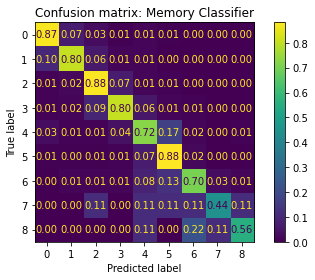

In [12]:
for mtype in ['mem', 'time']:
    if options[mtype]['explore_model']:
        X = model_data[mtype]['X_eval']
        y = model_data[mtype]['y_eval']
        plot_cm(X, y, model = model_data[mtype]['model'], 
                model_name = full_names[mtype],
                save=False, path='')

### Classification report

The next cell prints a classification report for each classifying model. To understand the statistics shown, consider the row corresponding to category 2:

Precision = what percentage of the entries for which the model guessed category 2 were actually in category 2

Recall = what percentage of the entries which were in category 2 were guessed as category 2 by the model

f1-Score = a weighted average of precision (P) and recall (R) for category 2, specifically (2PR)/(P+R). Ranges from 0.0 (worst) to 1.0 (best).

Support = how many entries belonged to category 2.

In [13]:
for mtype in ['mem', 'time']:
    if options[mtype]['explore_model']:
        X = model_data[mtype]['X_eval']
        y = model_data[mtype]['y_eval']
        
        print(f"{full_names[mtype]} classification report:")
        print_cr(X, y, model = model_data[mtype]['model'])

Memory Classifier classification report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5738
           1       0.83      0.80      0.82      2758
           2       0.81      0.88      0.85      2139
           3       0.74      0.80      0.77       820
           4       0.54      0.72      0.62       395
           5       0.80      0.88      0.84       651
           6       0.56      0.70      0.62        71
           7       0.21      0.44      0.29         9
           8       0.20      0.56      0.29         9

    accuracy                           0.85     12590
   macro avg       0.63      0.74      0.67     12590
weighted avg       0.86      0.85      0.85     12590



### ROC AUC score

The following cell prints ROC AUC scores for the two classifying models, that is, the area under the curve (AUC) of the Receiver Operating Characteristic curver (ROC). 

This is an average of ROC AUC scores for each individual category. The ROC AUC score for one category, say category 5 for example, represents the probability that when the model is given two random entries, one belonging to category 5 and one not, the model will assign a higher probability of being in category 5 to the entry that is actually in category 5. 

Hence the ROC AUC is always a score between 0.0 (worst) and 1.0 (best). 

In [14]:
for mtype in ['mem', 'time']:
    if options[mtype]['explore_model']:            
        X = model_data[mtype]['X_eval']
        y = model_data[mtype]['y_eval']
            
        print(f"{full_names[mtype]} ROC AUC score:")
        auc(X, y, model = model_data[mtype]['model'])

Memory Classifier ROC AUC score:
0.9617


### Regression accuracy score

The next cell prints the training and evaluation score of the regression model.
    
The score in this case R^2 coefficient, defined as 1 - u/v, where u is the sum over all samples of (y_true - y_pred)^2, and v is the sum over all samples of (y_true - y_mean)^2. 

The best possible score is 1.0, and scores can be negative, which would indicate that the model is worse than the strategy of always predicting the average value.

If the training score is much higher than the evaluation score, that's evidence that the model was overfitting.

In [15]:
if options['time_regr']['explore_model']:
    X_train_norm = model_data['time_regr']['X_train_norm']
    y_train = model_data['time_regr']['y_train']
    X_eval = model_data['time_regr']['X_eval']
    y_eval = model_data['time_regr']['y_eval']
    score_regressor(X_train_norm, y_train, X_eval, y_eval, 
                    model=model_data['time_regr']['model'])

Training score: 0.9429
Evaluation score: 0.9442


### Performance plot

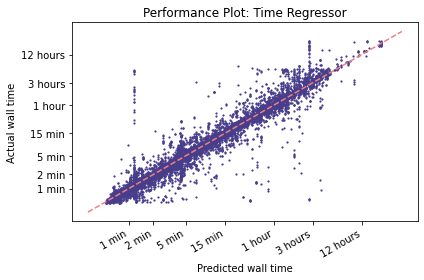

In [16]:
if options['time_regr']['explore_model']:
    X = model_data['time_regr']['X_eval']
    y = model_data['time_regr']['y_eval']
    plot_regr_performance(X, y, model=model_data['time_regr']['model'],
                     model_name=full_names['time_regr'], 
                     save=False, path='performance-plot.png')

## With custom predictions / scaling

The predictions in this section are designed to get a realistic idea of how the classification models perform, after the predictions are made in a custom way and the values are scaled how we like.

This next cell sets up several useful arrays for simulating these predictions ('custom_preds', 'custom_values', and 'eval_values'). The first array represents the predicted categories using custom prediction; the second array represents the predicted values (translating and scaling the predicted categories); and the third array represents the actual correct values (used_mem and wall_time from the original data).

In [17]:
for mtype in ['mem', 'time']:
    if options[mtype]['explore_model']:
        X = model_data[mtype]['X_eval']
        custom_preds = custom_predict(X, model_data[mtype]['model'])
        model_data[mtype]['custom_preds'] = custom_preds
        
        categories_dict = model_data[mtype]['categories_dict']
        custom_values = scale_predictions(translate_predictions(custom_preds, 
                                                                categories_dict),
                                          **settings[mtype+'_scaling'])
        model_data[mtype]['custom_values'] = custom_values
        
        if mtype == 'mem':
            target_name = 'used_mem'
        else:
            target_name = 'wall_time'
        if options[mtype]['training_mode'] == 'normal':
            eval_values = np.ravel(model_data[mtype]['y_val_full'][target_name])
        else:
            eval_values = np.ravel(model_data[mtype]['y_test_full'][target_name])

        model_data[mtype]['eval_values'] = eval_values

Here we show some example entries from the arrays we just made.

In [18]:
print(model_data['mem']['y_eval'][:5])
print(model_data['mem']['custom_preds'][:5])
print(model_data['mem']['eval_values'][:5])
print(model_data['mem']['custom_values'][:5])

[2 2 0 3 0]
[2 0 2 3 4]
[144.88671875 141.91015625  39.23046875 271.46484375  23.23046875]
[357, 108, 357, 681, 1100]


The next cell creates a dataframe containing all the relevant information for simulating the classifiers' behavior.

In the evaluation dataframe for the time classifier, we ignore entries where the wall time was reportedly more than 12 hours (we are not interested in predicting those).

In [19]:
def evaluation_df(mtype):
    if options[mtype]['training_mode'] == 'normal':
        df = model_data[mtype]['y_val_full'].copy()
    else:
        df = model_data[mtype]['y_test_full'].copy()
    if mtype == 'mem':
        df['old_delta'] = df.apply(lambda row: 
                               row['req_mem'] - row['used_mem'],
                               axis=1)
        df['pred_cat'] = model_data[mtype]['custom_preds']
        df['pred_value'] = model_data[mtype]['custom_values']
        
        df['pred_delta'] = df.apply(lambda row: row['pred_value'] - row['used_mem'],
                                    axis=1)
    else:
        df['time_delta'] = df.apply(lambda row: 
                               43200 - row['wall_time'],
                               axis=1)
        df['pred_cat'] = model_data[mtype]['custom_preds']
        df['pred_value'] = model_data[mtype]['custom_values']
        
        df['pred_delta'] = df.apply(lambda row: row['pred_value'] - row['wall_time'],
                                    axis=1)
        df = df[df.wall_time <= 43200]
        
    return df

Here we show an example of what this dataframe looks like.

In [20]:
evaluation_df('mem').head()

,req_mem,used_mem,mem_category,old_delta,pred_cat,pred_value,pred_delta
6146464,2048.0,144.886719,2,1903.113281,2,357,212.113281
6380917,1024.0,141.910156,2,882.089844,0,108,-33.910156
6732079,1024.0,39.230469,0,984.769531,2,357,317.769531
6512102,2048.0,271.464844,3,1776.535156,3,681,409.535156
6153542,1024.0,23.230469,0,1000.769531,4,1100,1076.769531


The next two cells do the simulation we have been preparing for throughout this section.

In [21]:
def total_loss_info(mtype):
    df = evaluation_df(mtype)
    print(f"Number of entries predicted: {df.shape[0]}")
    print("--------")
    num_bad_jobs = df[df.pred_delta < 0].shape[0]
    print("Number of jobs using more resources than predicted: "
          + f"{num_bad_jobs}")
    print("Average delta for jobs using more resources than predicted: "
          + f"{round(df[df.pred_delta<0]['pred_delta'].mean(), 2)}")
    print("Sample of jobs using more resources than predicted: ")
    if mtype == 'mem':
        print(df[df.pred_delta < 0].sample(min(5, num_bad_jobs)))
        print("--------")
        print("Total unused memory in GB (original): "
              + f"{round(df['old_delta'].sum()/1024)}")
        print("Total unused memory in GB (predicted): "
              + f"{round(df[df.pred_delta >= 0]['pred_delta'].sum()/1024)}")
    else:
        print(df[df.pred_delta < 0].sample(min(5, num_bad_jobs)))
        print("--------")
        print("Total unused time in years (original): "
              + f"{round(df['time_delta'].sum()/31536000, 4)}")
        print("Total unused time in years (predicted): "
              + f"{round(df[df.pred_delta >= 0]['pred_delta'].sum()/31536000, 4)}")

In [22]:
for mtype in ['mem', 'time']:
    if options[mtype]['explore_model']:
        print(f"Total loss info for {full_names[mtype]}:")
        total_loss_info(mtype)
        print('------------------')

Total loss info for Memory Classifier:
Number of entries predicted: 12590
--------
Number of jobs using more resources than predicted: 103
Average delta for jobs using more resources than predicted: -1822.99
Sample of jobs using more resources than predicted: 
         req_mem      used_mem  mem_category     old_delta  pred_cat  \
6542555   4096.0   1260.742188             5   2835.257812         3   
6205850  30720.0   3622.652344             6  27097.347656         5   
6178029  51200.0  14350.226562             7  36849.773438         6   
6145098   1024.0    888.980469             4    135.019531         0   
6377236    512.0    241.691406             3    270.308594         1   

         pred_value   pred_delta  
6542555         681  -579.742188  
6205850        2015 -1607.652344  
6178029       10000 -4350.226562  
6145098         108  -780.980469  
6377236         201   -40.691406  
--------
Total unused memory in GB (original): 67751
Total unused memory in GB (predicted): 4744